# Figure 2.11-14 

Model reduction of ODE metabolic networks

In [1]:
using DifferentialEquations
using Catalyst
using ModelingToolkit
using Plots
Plots.gr(lw=2)

Plots.GRBackend()

## Figure 2.11 : Full model

The full biochemical reaction model

In [2]:
fullModel = @reaction_network begin
    k_0, 0 --> A
    (k_1, k_m1), A <--> B
    k_2, B --> 0
end k_0 k_1 k_m1 k_2

Model ##ReactionSystem#257 with 4 equations
States (2):
  A(t)
  B(t)
Parameters (4):
  k_0
  k_1
  k_m1
  k_2

In [3]:
fullSys = convert(ODESystem, fullModel)

Model ##ReactionSystem#257 with 2 equations
States (2):
  A(t)
  B(t)
Parameters (4):
  k_0
  k_1
  k_m1
  k_2

In [4]:
speciesmap(fullSys)

Dict{Term{Real, Base.ImmutableDict{DataType, Any}}, Int64} with 2 entries:
  B(t) => 2
  A(t) => 1

In [5]:
paramsmap(fullSys)

Dict{Sym{Real, Base.ImmutableDict{DataType, Any}}, Int64} with 4 entries:
  k_0  => 1
  k_m1 => 3
  k_2  => 4
  k_1  => 2

In [6]:
params = [0, 9, 12, 2]
u0 = [0.0, 10.0]
tend = 3.0

3.0

In [7]:
sol1full = solve(ODEProblem(fullSys, u0, tend, params))

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 34-element Vector{Float64}:
 0.0
 8.33250002662905e-6
 9.165750029291953e-5
 0.0009249075029558242
 0.004925551957360877
 0.012950994749922366
 0.024203391128378236
 0.03867703241372845
 0.05687483596189583
 0.07885040292991835
 0.10491525261637588
 0.13531142723966036
 0.17058210067041177
 ⋮
 1.274482102556651
 1.448935061082541
 1.6048516285159593
 1.751791810142831
 1.8976421480307348
 2.0465348744106664
 2.199447810412539
 2.355340275358147
 2.5124116619064183
 2.66919607560664
 2.825050506773675
 3.0
u: 34-element Vector{Vector{Float64}}:
 [0.0, 10.0]
 [0.0009998041949395534, 9.99883355552422]
 [0.010987314386434823, 9.987180710981443]
 [0.10981641889273347, 9.871804396920822]
 [0.5587745957878649, 9.345993056329629]
 [1.3433471904639458, 8.41906301057267]
 [2.2233611426294853, 7.361953762978557]
 [3.060323185903145, 6.32762103387511]
 [3.771157

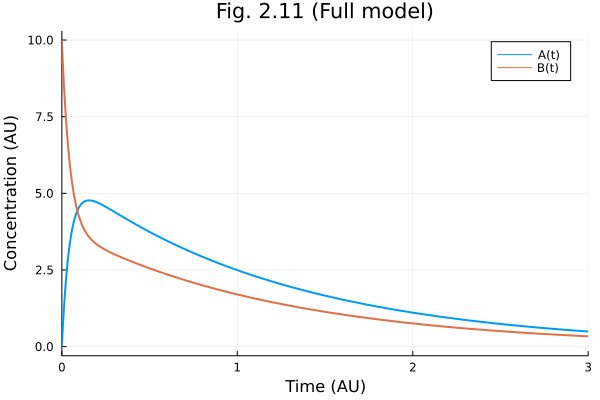

In [8]:
plot(sol1full, xlabel="Time (AU)", ylabel="Concentration (AU)", title="Fig. 2.11 (Full model)")

## Figure 2.12 : Rapid equilibrium assumption

In [9]:
reModel = @reaction_network begin
    (k_0, hill(k_1, k_2, k_m1, 1)), 0 <--> B
end k_0 k_1 k_m1 k_2

Model ##ReactionSystem#352 with 2 equations
States (1):
  B(t)
Parameters (4):
  k_0
  k_1
  k_2
  k_m1

In [10]:
speciesmap(reModel)

Dict{Term{Real, Base.ImmutableDict{DataType, Any}}, Int64} with 1 entry:
  B(t) => 1

In [11]:
paramsmap(reModel)

Dict{Sym{Real, Base.ImmutableDict{DataType, Any}}, Int64} with 4 entries:
  k_0  => 1
  k_2  => 3
  k_m1 => 4
  k_1  => 2

In [12]:
u0re = [sum(u0)]
sol1re = solve(ODEProblem(reModel, u0re, tend, params));

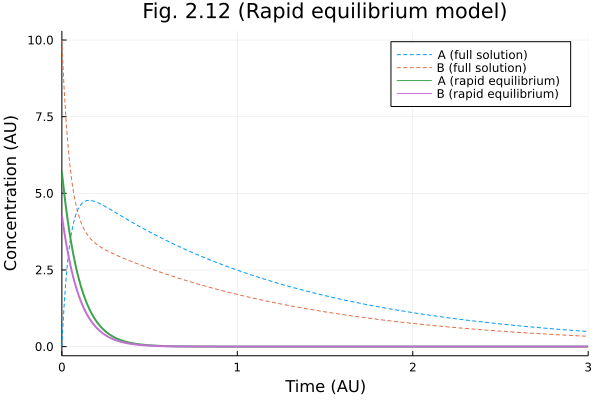

In [13]:
pl2 = plot(sol1full, line=(:dash, 1),label=["A (full solution)" "B (full solution)"])

fracA = params[3] / (params[3] + params[2])
fracB = 1 - fracA

plot!(pl2, sol1re, vars=((t, b̃)-> (t, b̃ * fracA), 0, 1), 
        label="A (rapid equilibrium)")
plot!(pl2, sol1re, vars=((t, b̃)-> (t, b̃ * fracB), 0, 1), 
        label="B (rapid equilibrium)")
plot!(pl2, title="Fig. 2.12 (Rapid equilibrium model)", 
        xlabel="Time (AU)", ylabel="Concentration (AU)")

## Figure 2.13: Rapid equilibrium 

with another set of parameters not suitable for Rapid equilibrium assumption.

In [14]:
tspan = 3.0
params = [9, 20, 12, 2]
u0 = [8, 4]
u0re = [sum(u0)]
sol2full = solve(ODEProblem(fullModel, u0, tspan, params));
sol2re = solve(ODEProblem(reModel, u0re, tspan, params));

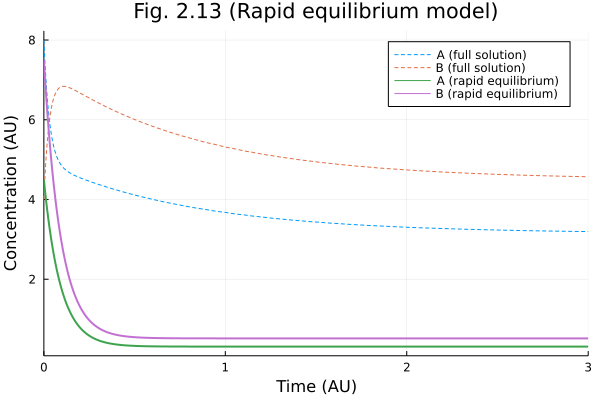

In [15]:
pl3 = plot(sol2full, line=(:dash, 1),label=["A (full solution)" "B (full solution)"])

fracA = params[3] / (params[3] + params[2])
fracB = 1 - fracA

plot!(pl3, sol2re, vars=((t, b̃)-> (t, b̃ * fracA), 0, 1), 
        label="A (rapid equilibrium)")
plot!(pl3, sol2re, vars=((t, b̃)-> (t, b̃ * fracB), 0, 1), 
        label="B (rapid equilibrium)")
plot!(pl3, title="Fig. 2.13 (Rapid equilibrium model)", 
        xlabel="Time (AU)", ylabel="Concentration (AU)")

## Figure 2.14 : QSSA

Quasi-steady state assumption on species A

In [16]:
qssModel = @reaction_network begin
    (k_0, k_2), 0 <--> B
end k_0 k_2

# The initial conditions in QSSA could be tricky
qss_u0(u0, k0, k1, km1, k2) = (k1 * sum(u0) - k0) / (k1 + km1)

qss_u0 (generic function with 1 method)

In [17]:
k0, k1, km1, k2 = params
u0qss = qss_u0(u0, k0, k1, km1, k2)

7.21875

In [18]:
paramsmap(qssModel)

Dict{Sym{Real, Base.ImmutableDict{DataType, Any}}, Int64} with 2 entries:
  k_0 => 1
  k_2 => 2

In [19]:
sol2qss = solve(ODEProblem(qssModel, [u0qss], tend, (k0, k2)))

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 11-element Vector{Float64}:
 0.0
 0.09213371408627077
 0.2580853720636457
 0.4579200621558787
 0.7105343618980664
 1.0087389420803021
 1.3646427506632768
 1.7813284514137806
 2.2736032791158305
 2.8565648455183186
 3.0
u: 11-element Vector{Vector{Float64}}:
 [7.21875]
 [6.761220680089925]
 [6.1225543617019555]
 [5.58799115197771]
 [5.156461132335911]
 [4.8615740496779285]
 [4.677452873414214]
 [4.577129233230205]
 [4.528831301128661]
 [4.5090025711834025]
 [4.506757412074749]

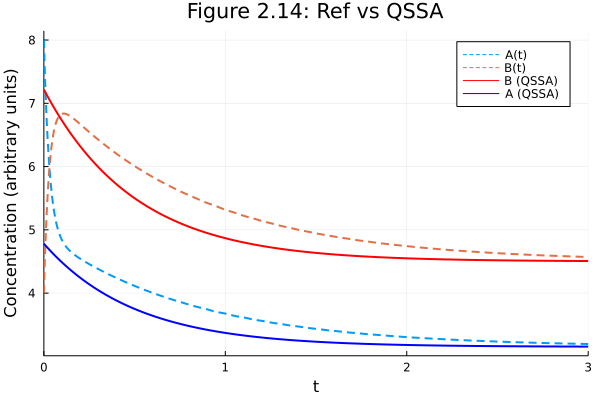

In [20]:
pl4 = plot(sol2full, line=(:dash, 2), xlims=tspan,
 xlabel="Time (arbitrary units)",
 ylabel="Concentration (arbitrary units)",
 title="Figure 2.14: Ref vs QSSA")

plot!(pl4, sol2qss, label="B (QSSA)", line=(2, :red))
plot!(pl4, sol2qss , vars= ((t, b) -> (t, (k0 + km1*b)/k1), 0, 1), label="A (QSSA)", line=(2, :blue))